# Example of generating a 1D2D model - an overview of functionalities

This notebook gives an overview of the functionalities of the D-HyDAMO module, part of the delft3dfmpy python package.

For install instructions see: https://github.com/openearth/delft3dfmpy#installation

Furthermore, it should be noted that recently added features were tested with dummy-data, which is included with this package. The generated model is, therefore, not necessarily a correct hydraulic representation, as some dummy structures were added and existing structures moved and/or adjusted. The purpose of this notebook is solely to illustrate the usage of the dhydamo module.

This notebook corresponds to a major update of delt3dfmpy and is, therefore, not compatible with older versions. The main differences are:
- input data should now be according the HyDAMO DAMO2.2 format instead of HyDAMO v12;
- input data is no longer in GML-format but is contained in a geopackage (GPKG);
- schematisation of paved nodes has changed. Within sewer areas, a paved node is created for every overflow location (which represents the corresponding fraction of the sewer area). Outside sewer areas, a paved node is created for the paved fraction of a catchment, which does NOT intersect with a sewage area;
- where the example catchment for older versions was the Moergestelsbroek, now the example model is based on a part of the Oostrumsche beek.


## Initialize

Load Python libraries

In [1]:
# Basis
import os
import sys
import shutil
from platform import python_version
import numpy as np
sys.path.append('../')      
# Importing relevant classes from delft3dfmpy
from delft3dfmpy import DFlowFMModel, HyDAMO, Rectangular, DFlowFMWriter
from delft3dfmpy import DFlowRRModel, DFlowRRWriter
from delft3dfmpy.datamodels.common import ExtendedGeoDataFrame

# shapefiles IO
import geopandas as gpd

# Import csv
import pandas as pd

# Geometries
from shapely.geometry import Polygon, LineString, Point

# Plotting
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# For reading SOBEK results as boundary conditions
# hkvsobekpy requires the modules fire and tqdm, install these (conda install fire tqdm)
import hkvsobekpy

%matplotlib inline

Change these paths to access the data and to use all functionalities. dflowfm_path is needed to refine the 2D-grid. It is not included in the D-Hydro installation. In the next major update, we will use meshkernel functionality and this executable will no longer be needed.

In [2]:
# path to the package containing the dummy-data
data_path = os.path.abspath('../00_Data')

# path to dflowfm. Optional; needed for 2d-mesh refining
# dflowfm_path = r'D:\dflowfm-x64-1.2.105.67228M'
dflowfm_path = os.path.abspath('../08_Software/dflowfm-x64-1.2.105.67228M')

# path to write the models
output_path = os.path.abspath('../03_Model/Raam_HH_lateralsV2')

# path to DIMR for a correct run.bat file
dimr_path = r"C:\Program Files\Deltares\D-HYDRO Suite 2023.01 1D2D\plugins\DeltaShell.Dimr\kernels\x64\dimr\scripts\run_dimr.bat"

In [3]:
# path to dll's that are needed to run gridgeom.dll, which is needed for 2D-mesh generation. Setting the path is only needed for Python >= version 3.8
if float('.'.join(python_version().split('.')[0:2])) >= 3.8: 
    dll_path = r'C:\Program Files\Deltares\D-HYDRO Suite 2023.01 1D2D\plugins\DeltaShell.Dimr\kernels\x64\share\bin'

## Read HYDAMO

Along with the HyDAMO DAMO2.2 format, the format of input data changed from GML to GPKG. 
In the following, we initialize a hydamo-instance and show the content of the GPKG-file containing all HyDAMO DAMO2.2 data.

In [4]:
data_path

'd:\\werkplan 2023\\kennisagenda\\23K01_dhydromodellering\\01-importeer-neerslag-afvoer-uit-modellen\\00_Data'

In [5]:
gpkg_file = os.path.join(data_path,'gpkg/AM.gpkg')
hydamo = HyDAMO(extent_file=os.path.join(data_path,'gis/HoogeRaam.shp'))
hydamo.branches.show_gpkg(gpkg_file)

Content of gpkg-file d:\werkplan 2023\kennisagenda\23K01_dhydromodellering\01-importeer-neerslag-afvoer-uit-modellen\00_Data\gpkg/AM.gpkg, containing 14 layers:
	INDEX	|	NAME                        	|	GEOM_TYPE      	|	 NFEATURES	|	   NFIELDS
	    0	|	regelmiddel                   	|	Point       	|	        57	|	         8
	    1	|	stuw                          	|	3D Point    	|	        57	|	         5
	    2	|	hydroobject                   	|	Line String 	|	       261	|	         4
	    3	|	gemaal                        	|	Point       	|	         2	|	         3
	    4	|	profiellijn                   	|	Line String 	|	       526	|	         3
	    5	|	profielpunt                   	|	3D Point    	|	      7777	|	         5
	    6	|	brug                          	|	Point       	|	        11	|	         8
	    7	|	duikersifonhevel              	|	Line String 	|	       375	|	        13
	    8	|	lateraleknoop                 	|	Point       	|	       179	|	         4
	    9	|	kunstwerkopening   

In the code section below the content of the GPKG is added. For more info on how to import its different elements, see: https://hkvconfluence.atlassian.net/wiki/spaces/DHYD/overview

The general steps for importing a HyDAMO object are:
- Read the objects from the GPKG file.
- Snap the structures to the branches
- Remove non-snapped structures, perhaps because the distance to the nearest branch was too large.

A few remarks:
- The converter requires a number column names with a specfic name. If the name in the GPKG layer does not match this name, it can be converted with the 'column_mapping'
- The branch or structure data can also be loaded from shapefiles. Note that shapefiles have a max column length of 10 characters, so probably a lot of column_mapping is necessary.

In [6]:
# branches
hydamo.branches.read_gpkg_layer(gpkg_file, layer_name='HydroObject', index_col='code')

# these branches are not connected to the main branch ('W_242466_0','W_242465_0','W_1386_0', 'W_2352_0') or have no profile (W_1698_0) - drop them.
# branches_to_drop = ['W_242466_0','W_242465_0','W_1386_0', 'W_1698_0', 'W_2352_0']
# hydamo.branches.drop(branches_to_drop, axis=0, inplace=True)

# profile points. Profiles that are associated with structures are connected through profile_line and profile_group objects.
hydamo.profile.read_gpkg_layer(gpkg_file, layer_name='ProfielPunt', groupby_column = 'profiellijnid', order_column='codevolgnummer') 
hydamo.profile_roughness.read_gpkg_layer(gpkg_file, layer_name='RuwheidProfiel') 
hydamo.profile.snap_to_branch(hydamo.branches, snap_method='intersecting')
hydamo.profile.dropna(axis=0, inplace=True, subset=['branch_offset'])
hydamo.profile_line.read_gpkg_layer(gpkg_file, layer_name='profiellijn', id_col='globalid')
hydamo.profile_group.read_gpkg_layer(gpkg_file, layer_name='profielgroep')
#hydamo.profile.drop('code', axis=1, inplace=True)
#hydamo.profile['code'] = hydamo.profile['profiellijnid']

# parametrised profile
#hydamo.param_profile.read_gpkg_layer(gpkg_file, layer_name='hydroobject_normgp')
#hydamo.param_profile_values.read_gpkg_layer(gpkg_file, layer_name='normgeparamprofielwaarde')

#culverts
hydamo.culverts.read_gpkg_layer(gpkg_file, layer_name='DuikerSifonHevel', index_col='code')
hydamo.culverts.snap_to_branch(hydamo.branches, snap_method='ends', maxdist=1)
hydamo.culverts.dropna(axis=0, inplace=True, subset=['branch_offset'])

# weirs - with associated 'kunstwerkopening' and 'regelmiddel'
hydamo.weirs.read_gpkg_layer(gpkg_file, layer_name='Stuw', index_col='code')
hydamo.weirs.snap_to_branch(hydamo.branches, snap_method='overal', maxdist=1)
hydamo.weirs.dropna(axis=0, inplace=True, subset=['branch_offset'])
hydamo.opening.read_gpkg_layer(gpkg_file, layer_name='Kunstwerkopening')
hydamo.management_device.read_gpkg_layer(gpkg_file, layer_name='Regelmiddel')

# pumps
#hydamo.pumpstations.read_gpkg_layer(gpkg_file, layer_name='Gemaal',index_col='code')
#hydamo.pumpstations.snap_to_branch(hydamo.branches, snap_method='overal', maxdist=1)
#hydamo.pumps.read_gpkg_layer(gpkg_file,layer_name='Pomp', index_col='code')
#hydamo.management.read_gpkg_layer(gpkg_file, layer_name='Sturing', index_col='code')

# bridge
hydamo.bridges.read_gpkg_layer(gpkg_file, layer_name='Brug', index_col='code')
hydamo.bridges.snap_to_branch(hydamo.branches, snap_method='overal', maxdist=1)
hydamo.bridges.dropna(axis=0, inplace=True, subset=['branch_offset'])

# boundary conditions
#hydamo.boundary_conditions.read_gpkg_layer(gpkg_file, layer_name='hydrologischerandvoorwaarde', index_col='code')
#hydamo.boundary_conditions.snap_to_branch(hydamo.branches, snap_method='overal', maxdist=1)
    

We do not need catchments if we do not schematise RR, but we can use the same locations of the laterals. In this case, the laterals include a column containing the specific discharge. The locations of the laterals are snapped to the branches.

In [20]:
laterals_shape = os.path.abspath(r'..\00_Data\output_afvoeren\shapefiles\lateralen_locations\lateralen_locations.shp')
#laterals_shape = r'd:\werkplan 2023\kennisagenda\23K01_dhydromodellering\01-importeer-neerslag-afvoer-uit-modellen\00_Data\gis\20230424_aangepast script Hoge Raam_lateralen\combinedoutput_aangepast.csv'
hydamo.laterals.read_shp(laterals_shape, column_mapping = {"index": "code"})
totaal_laterals = len(hydamo.laterals)
hydamo.laterals.snap_to_branch(hydamo.branches, snap_method='overal', maxdist=1000)
hydamo.laterals.dropna(axis=0, inplace=True, subset=['branch_offset'])
print('Aantal verwijderde lateralen na snappen:',totaal_laterals-len(hydamo.laterals))

Aantal verwijderde lateralen na snappen: 0


In [21]:
# hydamo.laterals.read_gpkg_layer(gpkg_file,layer_name='lateraleknoop')
# hydamo.laterals.snap_to_branch(hydamo.branches, snap_method='overal', maxdist=1000)

AttributeError: 'Series' object has no attribute 'crs'

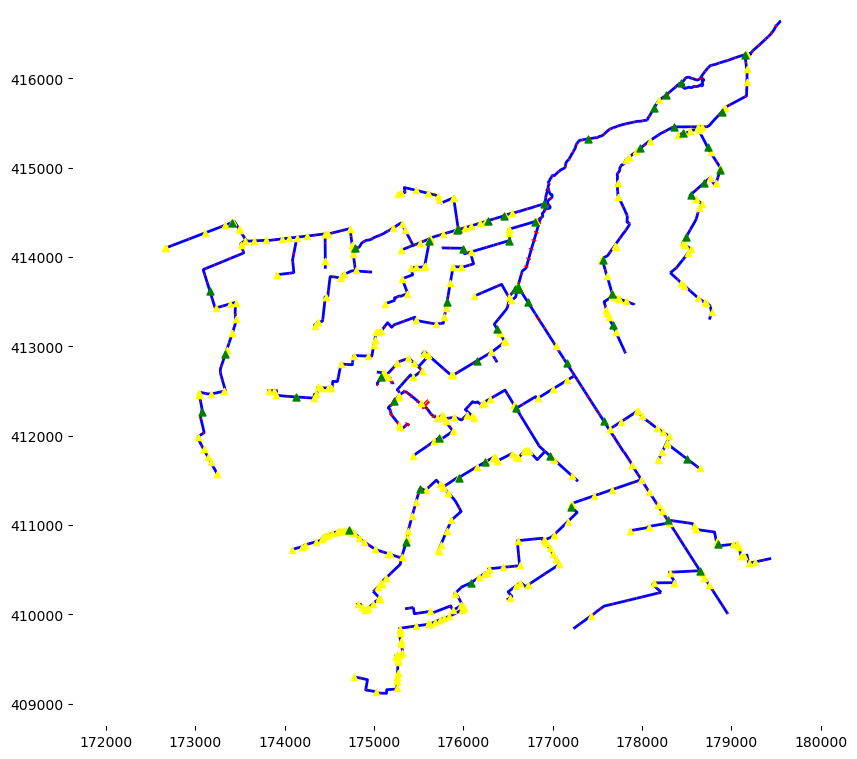

In [64]:
#fn_background = os.path.join(data_path, 'gis', 'achtergrond_oostrum.png')
plt.rcParams['axes.edgecolor'] = 'w'

fig, ax = plt.subplots(figsize=(10, 10))

# ax.fill(*hydamo.clipgeo.exterior.xy, color='w', alpha=0.5)
# ax.xaxis.set_visible(False)
# ax.yaxis.set_visible(False)
#map_extent = [189287.43330048519419506,389693.68099274818086997, 210845.66716714628273621,398529.35119274590397254]
ax.set_xlim(171630, 180306)
ax.set_ylim(408759, 416775)

#achtergrond = plt.imread(fn_background)
#ax.imshow(achtergrond, extent=(189287, 210845, 389693, 398529), interpolation='lanczos')

hydamo.branches.plot(ax=ax, label='Channel', linewidth=2, color='blue')
hydamo.profile.plot(ax=ax, color='red', label='Cross section', linewidth=1)
hydamo.culverts.centroid.plot(ax=ax, color='yellow', label='Culvert', markersize=20, zorder=10, marker='^')
hydamo.weirs.centroid.plot(ax=ax, color='green', label='Weir', markersize=25, zorder=10, marker='^')
hydamo.bridges.plot(ax=ax,color='red',label='Bridge',markersize=20,zorder=10, marker='^')
#hydamo.pumpstations.plot(ax=ax, color='orange', label='Pump', marker='s', markersize=125, zorder=10, facecolor='none', linewidth=2.5)
hydamo.boundary_conditions.plot(ax=ax, color='red', label='Boundary', marker='s', markersize=125, zorder=10, facecolor='red', linewidth=0)
ax.legend()

fig.tight_layout()

## Generate the D-HYDRO FM schematisation

### 1D-network

We first import the structures from the HyDAMO-object, since the structures' positions are necessary for defining the position of the 1D-mesh. Structures can also be added without the HyDAMO imports. One weir is added manually as an example, but equivalent functions are available for all implemented structures.

Note that for importing most structures multiple objects are needed from the GPKG. For more info on how to add structures (directly or from HyDAMO), see: https://hkvconfluence.atlassian.net/wiki/spaces/DHYD/overview.

 - for weirs, a corresponding profile is looked up in the crossections. If one is found, the weir is implemented as a universal weir. If it is not found, a regular (rectangular) weir will be used. The cross-section ('hydamo.profile') should be related through 'hydamo.profile_line' to a 'hydamo.profile_group', which contains a 'stuwid' column which is equal to the GlobalID of the corresponding weir. The weir object can also include orifices, in that case the field 'overlaatonderlaat' in the 'management_device-object ('regelmiddel') is 'onderlaat'. For weirs it should be 'overlaat'.
 
 - for culverts, a regelmiddel can be used to model a 'schuif' and/or a 'terugslagklep'. This is specified by the field 'soortregelmiddel'. In case of a 'terugslagklep', the flow direction is set to 'positive' instead of 'both'. In case of a 'schuif', a valve is implemented. Note that in DAMO2.2, an 'afsluitmiddel' can contain the same information. For now, only a regelmiddel (management_device) is implemented. In a next version, the flexibility to use both will be included. 
 
 - bridges need an associated crosssection. This is idential to universal weirs, but here the 'hydamo.profile_group'-object should contain a field 'brugid'. 
 
 - pumps are composed from 'hydamo.pumpstations', 'hydamo.pumps' and 'hydamo.managmement'. Only suction-side drection is implemented. Maximal capacity should be in m3/min.

In most cases, these 'extra' arguments are optional, i.e. they are not required and can be left out. Some are required:
- pumps really need all 3 objects ('hydamo.pumpstations', 'hydamo.pumps' and 'hydamo.managmement');
- bridges really need an associated crosssection (see above);

For more info on the structure definitions one is referred to the D-Flow FM user manual: https://content.oss.deltares.nl/delft3d/manuals/D-Flow_FM_User_Manual.pdf.

In [39]:
# Collect structures
dfmmodel = DFlowFMModel()
dfmmodel.structures.io.weirs_from_hydamo(hydamo.weirs, profile_groups=hydamo.profile_group, profile_lines=hydamo.profile_line, profiles=hydamo.profile, opening=hydamo.opening, management_device=hydamo.management_device, management=None)
dfmmodel.structures.io.culverts_from_hydamo(hydamo.culverts, management_device=hydamo.management_device)
dfmmodel.structures.io.bridges_from_hydamo(hydamo.bridges, profile_groups=hydamo.profile_group, profile_lines=hydamo.profile_line, profiles=hydamo.profile)
#dfmmodel.structures.io.pumps_from_hydamo(pompen=hydamo.pumps, sturing=hydamo.management, gemalen=hydamo.pumpstations)


It is also possible to add extra structures like this:

In [40]:
# dfmmodel.structures.add_weir(
#     id='extra_weir',
#     branchid='W_242213_0',
#     chainage=43.0,
#     crestlevel=18.00,
#     crestwidth=7.5,
#     corrcoeff=1.0    
# )

Add the branches and generate a 1D computational mesh.

In [41]:
dfmmodel.network.set_branches(hydamo.branches)
dfmmodel.network.generate_1dnetwork(one_d_mesh_distance=20.0, seperate_structures=True)

2023-04-25 14:18:35,606 - delft3dfmpy.core.dfm - dfm - WARNING - Some structures are not linked to a branch.


2023-04-25 14:18:35,614 - delft3dfmpy.core.dfm - dfm - INFO - Added 1d mesh nodes on branch 1050535 at: [0.0, 0.931, 360.9574671975111], due to the structures at [-0.001, 0.1, 1.762, 31.222, 354.392, 360.9584671975111].


INFO:delft3dfmpy.core.dfm:Added 1d mesh nodes on branch 1050535 at: [0.0, 0.931, 360.9574671975111], due to the structures at [-0.001, 0.1, 1.762, 31.222, 354.392, 360.9584671975111].


2023-04-25 14:18:35,617 - delft3dfmpy.core.dfm - dfm - INFO - Added 1d mesh nodes on branch 1050550 at: [0.0, 2.1664999999999996, 9.350701997646066], due to the structures at [-0.001, 0.1, 4.233, 9.351701997646066].


INFO:delft3dfmpy.core.dfm:Added 1d mesh nodes on branch 1050550 at: [0.0, 2.1664999999999996, 9.350701997646066], due to the structures at [-0.001, 0.1, 4.233, 9.351701997646066].


2023-04-25 14:18:35,622 - delft3dfmpy.core.dfm - dfm - INFO - Added 1d mesh nodes on branch 1051040 at: [0.0, 104.73599999999999, 114.233, 123.34838963865849], due to the structures at [-0.001, 39.55, 66.104, 98.999, 110.473, 117.993, 123.3493896386585].


INFO:delft3dfmpy.core.dfm:Added 1d mesh nodes on branch 1051040 at: [0.0, 104.73599999999999, 114.233, 123.34838963865849], due to the structures at [-0.001, 39.55, 66.104, 98.999, 110.473, 117.993, 123.3493896386585].


2023-04-25 14:18:35,635 - delft3dfmpy.core.dfm - dfm - INFO - Added 1d mesh nodes on branch 1052020 at: [0.0, 175.49849999999998, 189.772, 241.30849999999998, 307.76347953800416], due to the structures at [-0.001, 4.873, 36.792, 65.679, 116.566, 168.795, 182.202, 197.342, 233.035, 249.582, 273.292, 307.76447953800414].


INFO:delft3dfmpy.core.dfm:Added 1d mesh nodes on branch 1052020 at: [0.0, 175.49849999999998, 189.772, 241.30849999999998, 307.76347953800416], due to the structures at [-0.001, 4.873, 36.792, 65.679, 116.566, 168.795, 182.202, 197.342, 233.035, 249.582, 273.292, 307.76447953800414].


2023-04-25 14:18:35,641 - delft3dfmpy.core.dfm - dfm - INFO - Added 1d mesh nodes on branch 1052160 at: [0.0, 130.6755, 136.3005, 141.0744173243971], due to the structures at [-0.001, 76.125, 127.843, 133.508, 139.093, 141.0754173243971].


INFO:delft3dfmpy.core.dfm:Added 1d mesh nodes on branch 1052160 at: [0.0, 130.6755, 136.3005, 141.0744173243971], due to the structures at [-0.001, 76.125, 127.843, 133.508, 139.093, 141.0754173243971].


2023-04-25 14:18:35,648 - delft3dfmpy.core.dfm - dfm - INFO - Added 1d mesh nodes on branch 1052490 at: [0.0, 5.0495, 179.845, 192.89986446392757], due to the structures at [-0.001, 0.1, 9.999, 95.313, 133.57, 172.531, 187.159, 192.90086446392758].


INFO:delft3dfmpy.core.dfm:Added 1d mesh nodes on branch 1052490 at: [0.0, 5.0495, 179.845, 192.89986446392757], due to the structures at [-0.001, 0.1, 9.999, 95.313, 133.57, 172.531, 187.159, 192.90086446392758].


2023-04-25 14:18:35,651 - delft3dfmpy.core.dfm - dfm - INFO - Added 1d mesh nodes on branch 1052510 at: [0.0, 109.33449999999999, 435.95622884363763], due to the structures at [-0.001, 100.791, 117.878, 179.838, 435.9572288436376].


INFO:delft3dfmpy.core.dfm:Added 1d mesh nodes on branch 1052510 at: [0.0, 109.33449999999999, 435.95622884363763], due to the structures at [-0.001, 100.791, 117.878, 179.838, 435.9572288436376].


2023-04-25 14:18:35,656 - delft3dfmpy.core.dfm - dfm - INFO - Added 1d mesh nodes on branch 1052750 at: [0.0, 1.574, 184.42467741702043], due to the structures at [-0.001, 0.1, 3.048, 184.42567741702044].


INFO:delft3dfmpy.core.dfm:Added 1d mesh nodes on branch 1052750 at: [0.0, 1.574, 184.42467741702043], due to the structures at [-0.001, 0.1, 3.048, 184.42567741702044].


2023-04-25 14:18:35,668 - delft3dfmpy.core.dfm - dfm - INFO - Added 1d mesh nodes on branch 1053240 at: [0.0, 3.0084999999999997, 15.785740141725915], due to the structures at [-0.001, 0.1, 5.917, 15.786740141725915].


INFO:delft3dfmpy.core.dfm:Added 1d mesh nodes on branch 1053240 at: [0.0, 3.0084999999999997, 15.785740141725915], due to the structures at [-0.001, 0.1, 5.917, 15.786740141725915].


2023-04-25 14:18:35,677 - delft3dfmpy.core.dfm - dfm - INFO - Added 1d mesh nodes on branch 1054120 at: [0.0, 0.9485, 296.61510363066395], due to the structures at [-0.001, 0.1, 1.797, 218.251, 296.61610363066393].


INFO:delft3dfmpy.core.dfm:Added 1d mesh nodes on branch 1054120 at: [0.0, 0.9485, 296.61510363066395], due to the structures at [-0.001, 0.1, 1.797, 218.251, 296.61610363066393].


2023-04-25 14:18:35,682 - delft3dfmpy.core.dfm - dfm - INFO - Added 1d mesh nodes on branch 1054255 at: [0.0, 7.272, 80.82835720231877], due to the structures at [-0.001, 0.1, 14.444, 80.82935720231877].


INFO:delft3dfmpy.core.dfm:Added 1d mesh nodes on branch 1054255 at: [0.0, 7.272, 80.82835720231877], due to the structures at [-0.001, 0.1, 14.444, 80.82935720231877].


2023-04-25 14:18:35,689 - delft3dfmpy.core.dfm - dfm - INFO - Added 1d mesh nodes on branch 1055130 at: [0.0, 0.931, 7.8715, 271.5081690272575], due to the structures at [-0.001, 0.1, 1.762, 13.981, 129.36, 143.244, 271.5091690272575].


INFO:delft3dfmpy.core.dfm:Added 1d mesh nodes on branch 1055130 at: [0.0, 0.931, 7.8715, 271.5081690272575], due to the structures at [-0.001, 0.1, 1.762, 13.981, 129.36, 143.244, 271.5091690272575].


2023-04-25 14:18:35,699 - delft3dfmpy.core.dfm - dfm - INFO - Added 1d mesh nodes on branch 1055847 at: [0.0, 6.7255, 22.324067073625045], due to the structures at [-0.001, 1.555, 11.896, 22.325067073625046].


INFO:delft3dfmpy.core.dfm:Added 1d mesh nodes on branch 1055847 at: [0.0, 6.7255, 22.324067073625045], due to the structures at [-0.001, 1.555, 11.896, 22.325067073625046].


2023-04-25 14:18:35,702 - delft3dfmpy.core.dfm - dfm - INFO - Added 1d mesh nodes on branch 1055850 at: [0.0, 324.89182639080553, 331.41365278161106], due to the structures at [-0.001, 11.441, 166.899, 318.47, 331.31365278161104, 331.41465278161104].


INFO:delft3dfmpy.core.dfm:Added 1d mesh nodes on branch 1055850 at: [0.0, 324.89182639080553, 331.41365278161106], due to the structures at [-0.001, 11.441, 166.899, 318.47, 331.31365278161104, 331.41465278161104].


2023-04-25 14:18:35,706 - delft3dfmpy.core.dfm - dfm - INFO - Added 1d mesh nodes on branch 1055935 at: [0.0, 162.026, 173.8109148971553], due to the structures at [-0.001, 155.474, 168.578, 173.8119148971553].


INFO:delft3dfmpy.core.dfm:Added 1d mesh nodes on branch 1055935 at: [0.0, 162.026, 173.8109148971553], due to the structures at [-0.001, 155.474, 168.578, 173.8119148971553].


2023-04-25 14:18:35,715 - delft3dfmpy.core.dfm - dfm - INFO - Added 1d mesh nodes on branch 1057110 at: [0.0, 194.123, 264.79370070853156], due to the structures at [-0.001, 102.337, 187.456, 200.79, 260.379, 264.79470070853154].


INFO:delft3dfmpy.core.dfm:Added 1d mesh nodes on branch 1057110 at: [0.0, 194.123, 264.79370070853156], due to the structures at [-0.001, 102.337, 187.456, 200.79, 260.379, 264.79470070853154].


2023-04-25 14:18:35,718 - delft3dfmpy.core.dfm - dfm - INFO - Added 1d mesh nodes on branch 1057120 at: [0.0, 17.955484366623285, 29.29896873324657], due to the structures at [-0.001, 6.712, 29.19896873324657, 29.299968733246573].


INFO:delft3dfmpy.core.dfm:Added 1d mesh nodes on branch 1057120 at: [0.0, 17.955484366623285, 29.29896873324657], due to the structures at [-0.001, 6.712, 29.19896873324657, 29.299968733246573].


2023-04-25 14:18:35,721 - delft3dfmpy.core.dfm - dfm - INFO - Added 1d mesh nodes on branch 1057150 at: [0.0, 0.8525, 9.656, 23.16983343870851], due to the structures at [-0.001, 0.1, 1.605, 17.707, 23.17083343870851].


INFO:delft3dfmpy.core.dfm:Added 1d mesh nodes on branch 1057150 at: [0.0, 0.8525, 9.656, 23.16983343870851], due to the structures at [-0.001, 0.1, 1.605, 17.707, 23.17083343870851].


2023-04-25 14:18:35,727 - delft3dfmpy.core.dfm - dfm - INFO - Added 1d mesh nodes on branch 1057580 at: [0.0, 5.1055, 235.09687286880649], due to the structures at [-0.001, 0.1, 10.111, 235.0978728688065].


INFO:delft3dfmpy.core.dfm:Added 1d mesh nodes on branch 1057580 at: [0.0, 5.1055, 235.09687286880649], due to the structures at [-0.001, 0.1, 10.111, 235.0978728688065].


Add cross sections. Here two hydamo files are used. First the imported cross sections. If after this there are branch objects left without a cross sections, it is derived from the norm parametrised profile (Dutch: legger).

DAMO2.2 contains two roughness variants, 'ruwheidhoog' en ruwheidlaag'. Using roughness_variant, "High", or "Low", we choose one.

In [42]:
# Add cross sections from hydamo
hydamo.profile_group.dropna(subset=['brugid'], inplace=True)

dfmmodel.crosssections.io.from_hydamo(
    crosssections=hydamo.profile,
    crosssection_roughness=hydamo.profile_roughness,
    profile_group=hydamo.profile_group,
    profile_line=hydamo.profile_line,
    param_profile=hydamo.param_profile,
    param_profile_values=hydamo.param_profile_values,   
    branches=hydamo.branches,
    roughness_variant = 'High'
)

print(f'{len(dfmmodel.crosssections.get_branches_without_crosssection())} branches are still missing a cross section.')
print(f'{len(dfmmodel.crosssections.get_structures_without_crosssection())} structures are still missing a cross section.')

2023-04-25 14:18:40,877 - delft3dfmpy.io.dfmreader - dfmreader - INFO - Before adding the number of branches without cross section is: 261.


INFO:delft3dfmpy.io.dfmreader:Before adding the number of branches without cross section is: 261.


2023-04-25 14:18:42,358 - delft3dfmpy.io.dfmreader - dfmreader - INFO - After adding 'dwarsprofielen' the number of branches without cross section is: 27.


INFO:delft3dfmpy.io.dfmreader:After adding 'dwarsprofielen' the number of branches without cross section is: 27.


2023-04-25 14:18:42,365 - delft3dfmpy.io.dfmreader - dfmreader - INFO - After adding 'normgeparametriseerd' the number of branches without cross section is: 27.


INFO:delft3dfmpy.io.dfmreader:After adding 'normgeparametriseerd' the number of branches without cross section is: 27.


27 branches are still missing a cross section.
0 structures are still missing a cross section.


Plot the branches without crosssection.

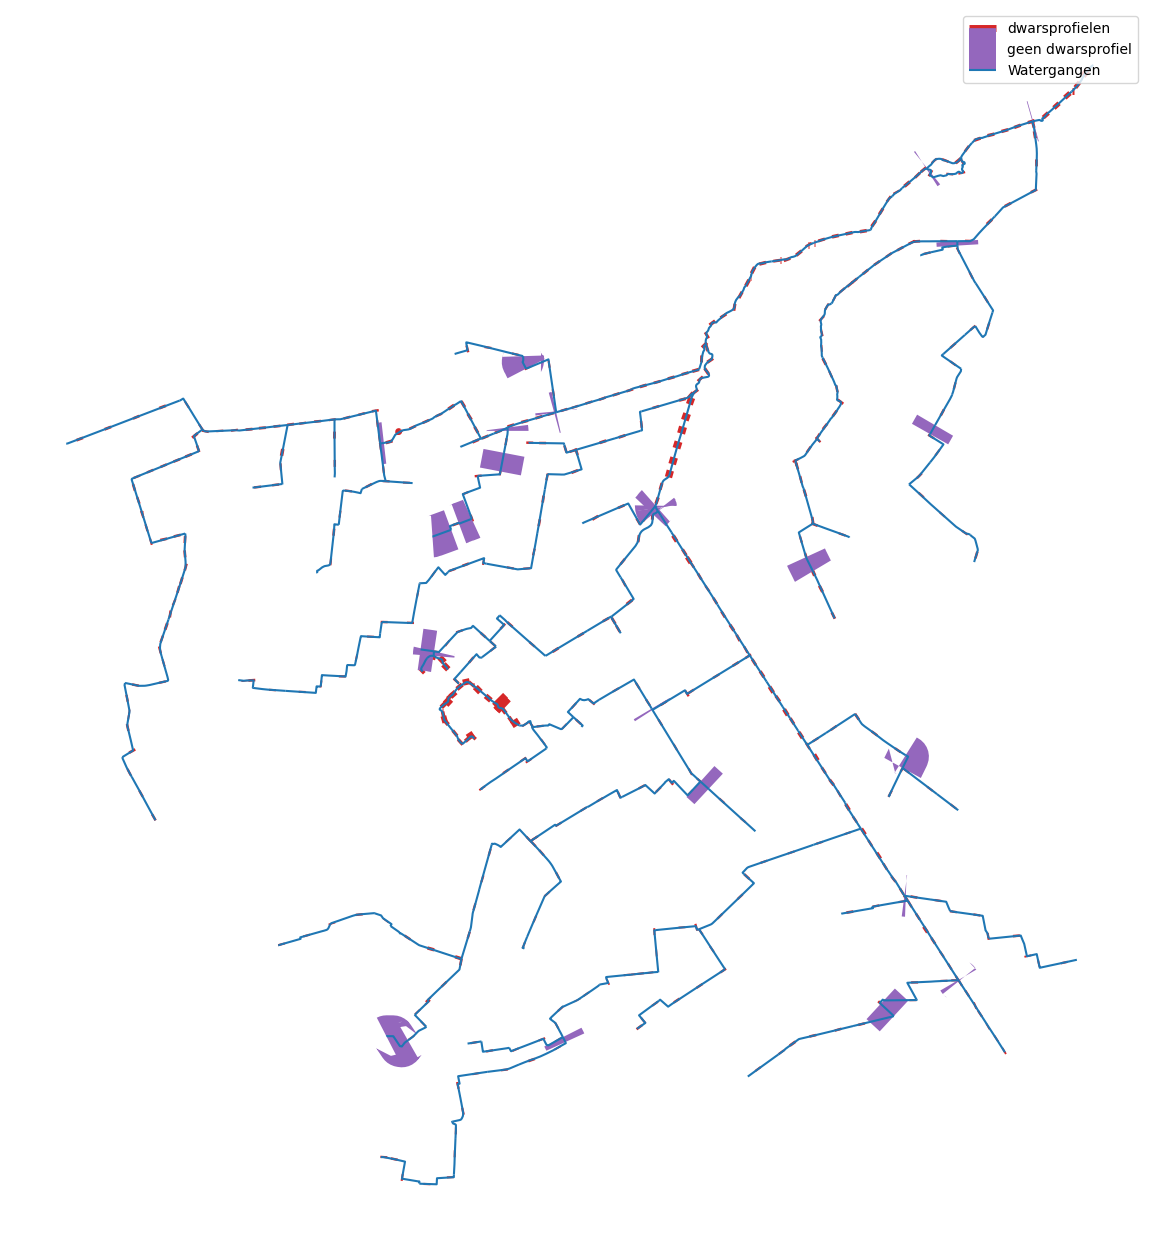

In [43]:
missing = dfmmodel.crosssections.get_branches_without_crosssection()
plt.rcParams['axes.edgecolor'] = 'w'
fig, ax = plt.subplots(figsize=(16, 16))

hydamo.profile.plot(ax=ax, color='C3', label='dwarsprofielen', linewidth=5)
hydamo.branches.loc[missing,:].plot(ax=ax, color='C4', label='geen dwarsprofiel',linewidth=30)
hydamo.branches.plot(ax=ax, label='Watergangen')
#gpd.read_file('../gis/roer_hoofdtak.shp').plot(ax=ax, color='C5', label='hoofdtak Roer',linewidth=4, alpha=0.5)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.legend()

Partly, missing crosssections can be resolved by interpolating over the main branch. We set all branches with identical names to the same order numbers and assign those to the branches. D-Hydro will then interpolate the cross-sections over the branches.

In [44]:
j=0
hydamo.branches['order'] = np.nan
for i in hydamo.branches.naam.unique():
    if i != None:
        if all(x in missing for x in hydamo.branches.loc[hydamo.branches.loc[:,'naam']==i, 'code']) == False:
            hydamo.branches.loc[hydamo.branches.loc[:,'naam']==i, 'order'] = int(j)
            j=j+1

interpolation=[]
for i in hydamo.branches.itertuples():
    if i.order > 0:
        dfmmodel.network.set_branch_order(hydamo.branches.loc[i.Index,'code'], idx= int(hydamo.branches.at[i.Index,'order']))
        interpolation.append(hydamo.branches.loc[i.Index,'code'])

In [45]:
#ordernummers handmatig toevoegen



order_add = [('1055940',9000),('1055945',9000),('1055930',9001),('1055935',9001),('1055920',9001)] 

for k in order_add:
    dfmmodel.network.set_branch_order(k[0], idx= k[1])


In [46]:
missing_after_interpolation =np.setdiff1d(missing,interpolation)
print('After interpolation', len(missing_after_interpolation), 'crosssections are missing.')

After interpolation 2 crosssections are missing.


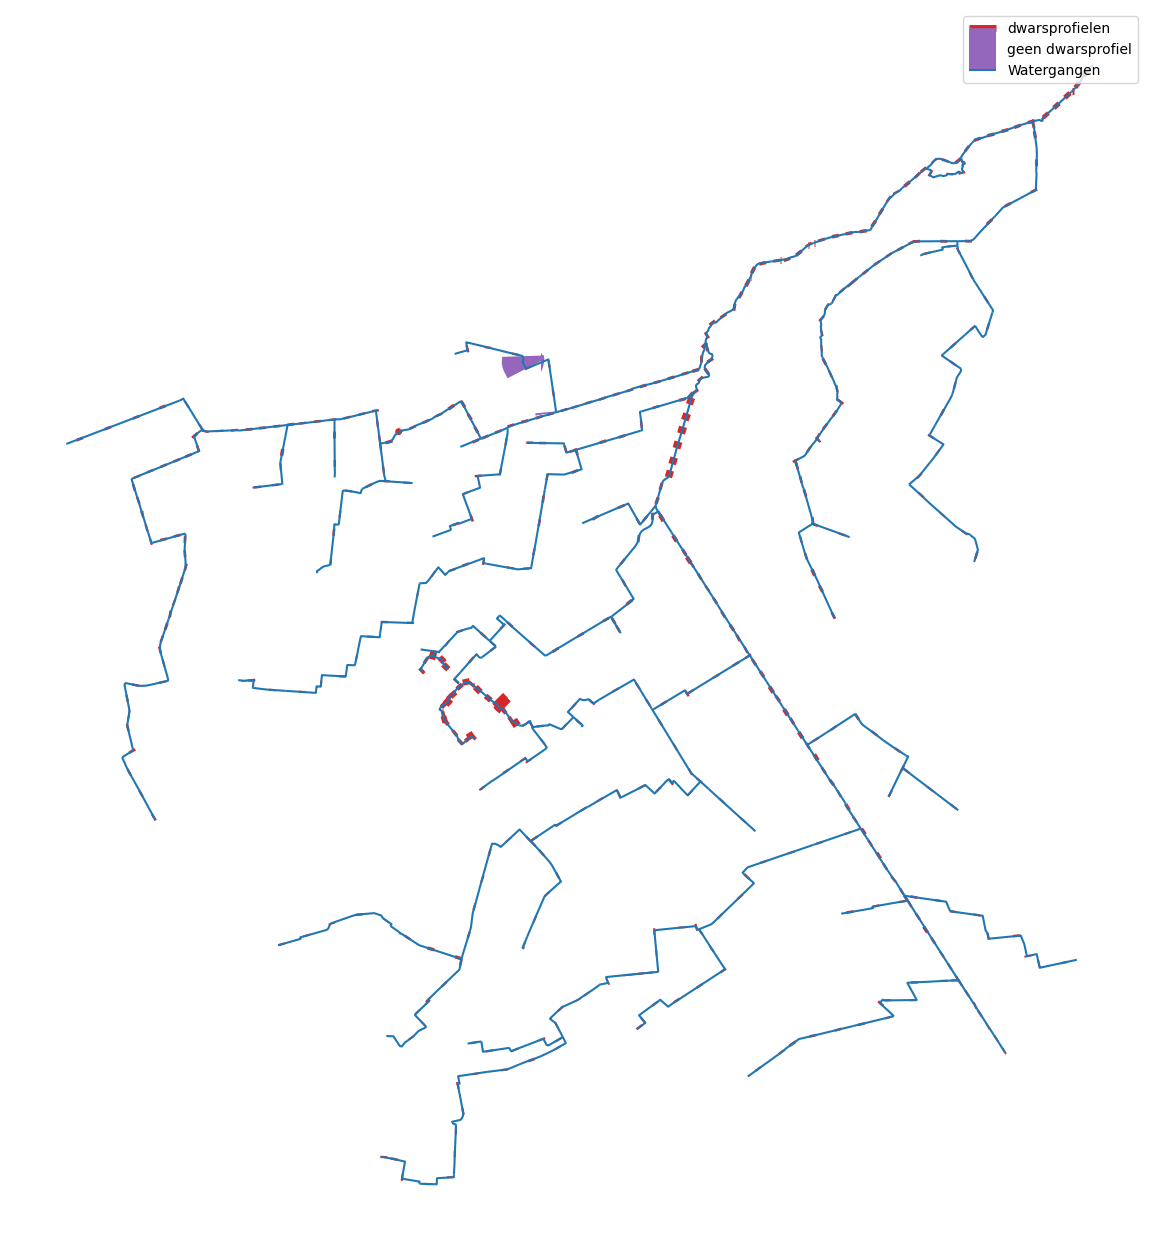

In [47]:
plt.rcParams['axes.edgecolor'] = 'w'
fig, ax = plt.subplots(figsize=(16, 16))

hydamo.profile.plot(ax=ax, color='C3', label='dwarsprofielen', linewidth=5)
hydamo.branches.loc[missing_after_interpolation,:].plot(ax=ax, color='C4', label='geen dwarsprofiel',linewidth=30)
hydamo.branches.plot(ax=ax, label='Watergangen')
#gpd.read_file('../gis/roer_hoofdtak.shp').plot(ax=ax, color='C5', label='hoofdtak Roer',linewidth=4, alpha=0.5)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.legend()

If there are still missing cross sections left, a default one can be added. To do so, add a cross section definition, and assign it with a vertical offset (shift). To prevent that default definitions are assigned to locations that will be interpolated, these locations can be specified.

In [ ]:
# Set a default cross section
# default = dfmmodel.crosssections.add_rectangle_definition(
#     height=5.0, width=5.0, closed=False, roughnesstype='Strickler', roughnessvalue=30, name='default')
# dfmmodel.crosssections.set_default_definition(definition=default, shift=18.0)
# dfmmodel.crosssections.set_default_locations(missing_after_interpolation)

### Boundary condititions

Boundary conditions can be set from HyDAMO (as previously read) or added here. Here, because we use a subset of the Oostrumsche beek, we read the downstream water level boundary from the DAMO2.2 data and add a discharge boundary condition at the upper boundary.

In [48]:
dfmmodel.external_forcings.io.from_hydamo(hydamo.boundary_conditions)
dfmmodel.external_forcings.add_boundary_condition('GraafscheRaam', (179557.,416643.),  'waterlevel', 7.15)

### Initial conditions

Set the initial water depth to 0.5 m. It is also possible to set a global water level using the equivalent function "set_initial_waterlevel".

In [49]:
# # Initial water depth is set to 0.5 m
dfmmodel.external_forcings.set_initial_waterdepth(0.5)

### Lateral discharges

Lateral discharges are schematised using the function 'read_laterals', which receives as arguments the locations of the laterals (see above), discharge (timeseries) and, if applicable, RR-boundaries (not present here).

The function first tries to couple a lateral location to an RR-boundary. In D-Hydro, a real-time coupling is created. If no RR-boundary is found, the lateral-discharges object is searched for the lateral. This object can be of two types:
- a Pandas series, that contains one number (in m3/s) for every lateral. The 'code' of the lateral should be the index of the series. See example below.
- a Pandas dataframe containing time series, with a column for every lateral node. The 'code' of the lateral should be equal to the column names, and the index should contain the timestamps.

Onderstaande code is om te rekenen met stationaire afvoeren. 

In [50]:
# lateral_discharges = hydamo.laterals.afvoer
# lateral_discharges.index = hydamo.laterals.code
# dfmmodel.external_forcings.io.read_laterals(locations=hydamo.laterals, lateral_discharges=lateral_discharges, rr_boundaries=None)

Onderstaande code is om te rekenen met afvoergolven.

In [53]:
path_discharge = os.path.abspath(r'..\00_Data\output_afvoeren\timeseries\combinedoutput.csv')
#lateral_discharge = pd.read_csv(r'..\00_Dataoutput_afvoeren\timeseries\combinedoutput.csv',sep=';')
lateral_discharge = pd.read_csv(path_discharge,sep=';',skiprows=1,index_col=0, parse_dates=True)
#date_format='%Y-%m-%d %h:%m:%s'
lateral_discharge
dfmmodel.external_forcings.io.read_laterals(locations=hydamo.laterals, lateral_discharges=lateral_discharge, rr_boundaries=None)


2023-04-25 14:21:33,546 - delft3dfmpy.io.dfmreader - dfmreader - WARNING - No data found for MIL-LAN-ESP-12. Skipping.


In [55]:
# ###For adding the lateral inflow we import SOBEK results. To do so we use hkvsobekpy. For more info on this module, see: https://github.com/HKV-products-services/hkvsobekpy
# # # Add the lateral inflows also from the SOBEK results. Naote that the column names in the his-file need to match
# # # the id's of the imported lateral locations at the top of this notebook.
# rehis = hkvsobekpy.read_his.ReadMetadata(data_path+'/sobekdata/GHG70.HIS', hia_file='auto')
# param = [p for p in rehis.GetParameters() if 'disch' in p][0]
# lateral_discharges_SOBEK = rehis.DataFrame().loc[:, param]
# #dfmmodel.external_forcings.io.read_laterals(locations=hydamo.laterals, lateral_discharges=lateral_discharges, rr_boundaries=None)
# #lateral_discharge.drop('lat_986', inplace=True, axis=1)

In [56]:
lateral_discharge

,1057660L,1055340L,1055935L,1056150L,1057380L,1057400L,1050020L,1050120L,1050545L,1051250L,...,VEG-VEG-WES-28,VEG-VEG-WES-30,VEG-VEG-ZUI-15,VEG-VEG-ZUI-16,VEG-VEG-ZUI-17,VEG-ZIJ-KER-52,VEG-ZIJ-RUD-53,GEM-BAK-SPE-27,LAN-SCH-LOU-3,HEL-STI-KER-66
2010-11-09 00:00:00,0.000749,0.000548,0.001379,0.001638,0.000225,0.000178,0.000843,0.007369,0.000695,0.000966,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-11-09 01:00:00,0.000747,0.000547,0.001376,0.001635,0.000225,0.000178,0.000841,0.007354,0.000694,0.000964,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-11-09 02:00:00,0.000746,0.000546,0.001374,0.001632,0.000225,0.000178,0.000840,0.007342,0.000693,0.000963,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-11-09 03:00:00,0.000745,0.000545,0.001372,0.001630,0.000224,0.000178,0.000839,0.007330,0.000691,0.000961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-11-09 04:00:00,0.000744,0.000544,0.001370,0.001627,0.000224,0.000177,0.000837,0.007318,0.000690,0.000960,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-11-21 19:00:00,0.000578,0.000423,0.001064,0.001265,0.000174,0.000138,0.000651,0.005688,0.000536,0.000746,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-11-21 20:00:00,0.000577,0.000422,0.001063,0.001263,0.000174,0.000138,0.000650,0.005682,0.000536,0.000745,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-11-21 21:00:00,0.000577,0.000422,0.001062,0.001262,0.000174,0.000137,0.000649,0.005676,0.000535,0.000744,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-11-21 22:00:00,0.000577,0.000422,0.001062,0.001261,0.000174,0.000137,0.000649,0.005673,0.000535,0.000744,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Generate the 2D mesh

To add a mesh, currently 2 options exist:
1. The converter can generate a relatively simple, rectangular mesh, with a rotation or refinement. Note that rotation _and_ refinement is currently not possible. In the section below we generate a refined 2D mesh with the following steps:

    - Generate grid within a polygon. The polygon is the extent given to the HyDAMO model.
    - Refine along the main branch
    - Determine altitude from a DEM.

    The 'refine'-method requires the dflowfm.exe executable. If this is not added to the system path, it can be provided in an optional argument to refine (dflowfm_path).

In [57]:
model2D=False
if model2D==True:
    # # Create mesh object
    mesh = Rectangular()
    cellsize = 25

    # # Generate mesh within the defined bounds in the shapefile 2D_extent
    if float('.'.join(python_version().split('.')[0:2])) >= 3.8:
         os.add_dll_directory(dll_path)

    extent2D = gpd.read_file(r"../00_Data/gis/HoogeRaam.shp")
    # bgt = gpd.read_file(r"../data/gis/bgt.shp")

    # uitknippen = extent2D.unary_union - bgt.unary_union

    #mesh.generate_within_polygon(uitknippen, cellsize=cellsize, rotation=0)
    mesh.generate_within_polygon(extent2D.unary_union, cellsize=cellsize, rotation=0)

    # # Refine the model (2 steps) along the main branch. To do so we generate a buffer around the main branch.
    # buffered_branch = hydamo.branches.loc[['W_242223_0', 'W_242224_0'], 'geometry'].unary_union.buffer(10)

    # # optional: only possible with dflowfm.exe
    # buffered_branch = gpd.read_file(r"../data/gis/BGT.shp")
    # mesh.refine(polygon=[buffered_branch], level=[1], cellsize=cellsize, dflowfm_path=dflowfm_path)

    # # Determine the altitude from a digital elevation model
    rasterpath = '../00_Data/rasters/ahn4_5.tif'
    mesh.altitude_from_raster(rasterpath)

    # # The full DEM is not added to this notebook. Instead a constant bed level is used
    # # mesh.altitude_constant(20.0)

    # # Add to schematisation
    dfmmodel.network.add_mesh2d(mesh)

2) a more complex mesh can be created in other software (such as SMS) and then imported in the converter: (uncomment to activate)

In [58]:
# from dhydamo.core.mesh2d import Mesh2D
# mesh = Mesh2D()
# #import the geometry
# mesh.geom_from_netcdf(r'T:\2Hugo\Grid_Roer_net.nc')
# fill every cell with an elevation value
# mesh.altitude_from_raster(rasterpath)
# and add to the model
# dfmmodel.network.add_mesh2d(mesh)

### Add 1D2D-links

For linking the 1D and 2D model, three options are available:
1. Generating links from each 1d node to the nearest 2d node.
2. Generating links from each 2d node to the nearest 1d node (intersecting==True)
3. Generating links from each 2d node to the nearest 1d node, while not allowing the links to intersect other cells (intersecting==True).

Intersecting indicates whether or not the 2D cells cross the 1D network (lateral versus embedded links).
So, option 3 is relevant when there is no 2d mesh on top of the 1d mesh: the lateral links.

Note that for each option a maximum link length can be chosen, to prevent creating long (and perhaps unrealistic) links.

In [59]:
# del dfmmodel.network.links1d2d.faces2d[:]
# del dfmmodel.network.links1d2d.nodes1d[:]

# # Generate 1D2D links with a maximum length of 50 m
# dfmmodel.network.links1d2d.generate_1d_to_2d(max_distance=50)

# # No links will be generated from 1D nodes with a boundary condition
# dfmmodel.network.links1d2d.remove_1d_endpoints()

In [60]:
# fig, ax = plt.subplots(figsize=(13, 10))
# ax.set_aspect(1.0)

# segments = dfmmodel.network.mesh2d.get_segments()
# ax.add_collection(LineCollection(segments, color='0.3', linewidths=0.5, label='2D-mesh'))

# links = dfmmodel.network.links1d2d.get_1d2dlinks()
# ax.add_collection(LineCollection(links, color='k', linewidths=0.5))
# ax.plot(links[:, :, 0].ravel(), links[:, :, 1].ravel(), color='k', marker='.', ls='', label='1D2D-links')

# # for i, p in enumerate([buffered_branch]):
# #     ax.plot(*p.exterior.xy, color='C3', lw=1.5, zorder=10, alpha=0.8, label='Refinement buffer' if i==0 else None)

# hydamo.branches.plot(ax=ax, color='C0', lw=2.5, alpha=0.8, label='1D-mesh')

# ax.legend()

# ax.set_xlim(171629, 180305)
# ax.set_ylim(408759, 416775);

### Observation points

Observation points are now written in the new format, where once can discriminate between 1D ('1d') and 2D ('2d') observation points. This can be done using the optional argument 'locationTypes'. If it is omitted, all points are assumed to be 1d. 1D-points are always snapped to a the nearest branch. 2D-observation points are always defined by their X/Y-coordinates.

Note: add_points can be called only once: once dfmodel.observation_points is filled,the add_points-method is not available anymore. Observation point coordinates can be definied eiher as an (x,y)-tuple or as a shapely Point-object.

In [61]:
#dfmmodel.observation_points.add_points([Point((200200,395600)),(200200,396200)],['ObsPt1','ObsPt2'], locationTypes=['1d','1d'], snap_distance=10.)

## Writing the model

### Settings and writing

Finally, we adjust some settings and export the FM-model. For more info on the settings: https://content.oss.deltares.nl/delft3d/manuals/D-Flow_FM_User_Manual.pdf

The 1D/2D model (FM) is written to the sub-folder 'fm'. By adding 'dimr_path', also a dimr-config and a run.bat is included in the fm-folder to to run the model in DIMR. To open in the GUI, import dimr_config.xml or the MDU.

In [62]:
# for FM model
dfmmodel.mdu_parameters['refdate'] = 20101109
dfmmodel.mdu_parameters['tstart'] = 0 * 3600
dfmmodel.mdu_parameters['tstop'] =  20.0 * 12 * 3600
dfmmodel.mdu_parameters['hisinterval'] = '3600. 0. 1036800.'
dfmmodel.mdu_parameters['mapinterval'] = '3600. 0. 1036800.'
dfmmodel.mdu_parameters['cflmax'] = 0.7
dfmmodel.mdu_parameters['OutputDir'] = 'output'
dfmmodel.mdu_parameters['useVolumeTables'] = 1 # oparameter setting advised by Deltares for better performance
dfmmodel.mdu_parameters['increment'] = 0.2 # oparameter setting advised by Deltares for better performance
dfmmodel.mdu_parameters['NcFormat'] = 4 # oparameter setting advised by Deltares for better performance
dfmmodel.mdu_parameters['NcNoForcedFlush'] = 1 # oparameter setting advised by Deltares for better performance
dfmmodel.mdu_parameters['MapFormat'] = 4 # oparameter setting advised by Deltares for better performance
dfmmodel.mdu_parameters['NcNoUnlimited'] = 1 # oparameter setting advised by Deltares for better performance

dfmmodel.dimr_path = dimr_path

print('Writing model')

# # Create writer
fm_writer = DFlowFMWriter(dfmmodel, output_dir= output_path, name='Hooge Raam')

# # Write as model
# fm_writer.objects_to_ldb()

Writing model


In [63]:
fm_writer.write_all()

Finished! Start the coupled model by clicking run.bat in the output model, or import the dimr_config.xml in the GUI.